Ноутбук по переводу UMLS CUI в pt meddra и переводу на рус. англоязычных датасетов, а также подсчету статистики

In [4]:
import os
import xml.etree.ElementTree as ET
#from nltk.stem import WordNetLemmatizer
#import nltk
#from nltk.corpus import wordnet
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import jsonlines
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
import json
import stanza
from tqdm import tqdm
from torch.cuda import is_available
from copy import copy
import re
import os
from collections import UserDict
from os.path import exists
#lang = detect("Ein, zwei, drei, vier")

In [2]:
stanza.download('en')
stanza.download('ru')

2022-04-08 15:03:16 INFO: Downloading default packages for language: en (English)...
2022-04-08 15:03:24 INFO: File exists: /home/romanrybka/stanza_resources/en/default.zip.
2022-04-08 15:03:28 INFO: Finished downloading models and saved to /home/romanrybka/stanza_resources.


2022-04-08 15:03:28 INFO: Downloading default packages for language: ru (Russian)...
2022-04-08 15:03:37 INFO: File exists: /home/romanrybka/stanza_resources/ru/default.zip.
2022-04-08 15:03:44 INFO: Finished downloading models and saved to /home/romanrybka/stanza_resources.


In [ ]:
nltk.download('punkt')

In [ ]:
nltk.download('omw-1.4')

<h2>Инициализация необходимых объектов, функций, классов</h2>

<h3>Маппинг кодов с концептами pt</h3>

In [5]:
class MeddraHelper():
    def __init__(self, meddra_path_pt, meddra_path_llt, umls_path, lang='ENG'):
        assert lang in ['ENG', 'RUS'], "Choose 'RUS' or 'ENG'"
        self.meddra_path_pt = meddra_path_pt
        self.meddra_path_llt = meddra_path_llt
        self.umls_path = umls_path
        self.language = lang
        self.ptcodes = []
        self.ptcode_to_pt = {}
        self.pt_to_ptcode = {}
        self.umlscode_to_ptcode = {}
        self.umlscode_to_pt = {}
        self.umlscode_to_lltcode = {}
        self.umlscode_to_llt = {}
        self.lltcode_to_ptcode = {}
        self.llt_to_lltcode = {}
        self.Load()

    def Load(self):
        """
        собираем из медры только то, что надо, а именно:
        - все пт коды для быстрой проверки, является ли найденный где-то код PT кодом
        """
        with open(self.meddra_path_pt, "r") as f:
            for pt_line in f:
                pt_line = pt_line.split("$")
                self.ptcodes.append(pt_line[0])
                self.ptcode_to_pt[pt_line[0]] = pt_line[1]
                self.pt_to_ptcode[pt_line[1]] = pt_line[0]
                
        with open(self.meddra_path_llt, "r") as f:
            for llt_line in f:
                llt_line = llt_line.split("$")
                self.lltcode_to_ptcode[llt_line[0]] = llt_line[2]
                self.llt_to_lltcode[llt_line[1]] = llt_line[0]
        
        with open(self.umls_path, "r") as f: #./Data/ExternalMRCONSO.RRF 12 и 13 строки
            for umls_line in f:
                umls_line_values = umls_line.split('|')
                umls_meddra_flag, umls_meddra_pt_or_llt_flag, lang_flag = umls_line_values[11], umls_line_values[12], umls_line_values[1] 
                umls_meddra_flag = True if umls_meddra_flag=='MDR' else False
                umls_meddra_pt_flag = True if umls_meddra_pt_or_llt_flag=='PT' else False
                umls_meddra_llt_flag = True if umls_meddra_pt_or_llt_flag=='LLT' else False
                lang_flag = True if self.language == lang_flag else False
                if not umls_meddra_flag or not (umls_meddra_pt_flag or umls_meddra_llt_flag)  or not lang_flag:
                    continue
                umls_code = umls_line_values[0]
                meddra_code = umls_line_values[10] 
                meddra_term = umls_line_values[14]
                if umls_meddra_pt_flag:
                    self.umlscode_to_ptcode[umls_code] = meddra_code
                    self.umlscode_to_pt[umls_code] = meddra_term
                if umls_meddra_llt_flag:
                    self.umlscode_to_lltcode[umls_code] = meddra_code
                    self.umlscode_to_llt[umls_code] = meddra_term
                    
    def force_umlscode_to_ptcode(self, umls_code):
        #если код umls не приводится сразу к pt
        #тогда пробуем привести к llt, затем к pt
        if umls_code in self.umlscode_to_ptcode.keys():
            return self.umlscode_to_ptcode[umls_code]
        elif umls_code in self.umlscode_to_lltcode.keys():
            return self.lltcode_to_ptcode[self.umlscode_to_lltcode[umls_code]]
        else:
            return None
        


In [6]:
class CorpStat(UserDict):
    @staticmethod
    def load_stat_for_corp(corp_name, lang, lemmatize):
        lemmatized_str = '_lemmatized' if lemmatize else ''
        print('loading corpus %s statistic, lang: %s, lemmatize: %s'%(corp_name, lang, lemmatize))
        with open('./CorpsStatisticData/%s_%s%s.json'%(corp_name, lang, lemmatized_str), 'r') as f:
            data = json.load(f)
            count_stat_dict = CorpStat({k:set(v) for k,v in data.items()})
        count_stat_dict.corp_name = corp_name
        count_stat_dict.lang = lang
        count_stat_dict.lemmatize = lemmatize
        return count_stat_dict
    
    @staticmethod     
    def check_saved_stat_for_corp(corp_name, lang, lemmatize):
        lemmatized_str = '_lemmatized' if lemmatize else ''
        if exists('./CorpsStatisticData/%s_%s%s.json'%(corp_name, lang, lemmatized_str)):
            return True
        else:
            return False
    
    def __init__(self, data, corp_name=None, lang=None, lemmatize=None):
        super(CorpStat, self).__init__(data)
        if corp_name:
            self.corp_name=corp_name
        if lang:
            self.lang=lang
        if lemmatize:
            self.lemmatize=lemmatize
        #обязательно должен быть вызван этот метод
        self.count_codes_len()
            
    def save_stat_for_corp(self):
        lemmatized_str = '_lemmatized' if self.lemmatize else ''
        if not exists('./CorpsStatisticData'):
            os.mkdir('./CorpsStatisticData')
        print('saving corpus %s statistic, lang: %s, lemmatize: %s'%(self.corp_name, self.lang, self.lemmatize))
        data = {k: list(v) for k,v in self.map_codes_to_phrases.items()}
        with open('./CorpsStatisticData/%s_%s%s.json'%(self.corp_name, self.lang, lemmatized_str), 'w') as f:
            json.dump(data, f)
    
    def count_codes_len(self):
        if hasattr(self, 'map_codes_to_phrases'):
            return
        self.map_codes_to_phrases = copy(self.data)
        self.data = {k: len(v) for k, v in self.data.items()}
        
    def get_uniq_phrases_set(self):
        if not hasattr(self, 'uniq_phrases_li'):
            self.uniq_phrases_li = set(sum([list(phrases_set) for phrases_set \
                                                  in self.map_codes_to_phrases.values()], []))

        return self.uniq_phrases_li
    

<h3>Функции по сбору статистики и лемматизации</h3>

In [7]:
def lemmatize_phrase(phrase, lang='en'):
    if lang=='ru':
        lemmatization_pipe = lemmatization_pipe_ru
    elif lang=='en':
        lemmatization_pipe = lemmatization_pipe_en
    else:
        raise AssertionError('language %s is not supported'%lang)
    doc = lemmatization_pipe(phrase)
    return ' '.join([word.lemma for sent in doc.sentences for word in sent.words])        

def tokenize_text(text, lang='en'):
    if lang=='ru':
        tokenizer = tokenizer_ru
    else:
        tokenizer = tokenizer_en
    doc = tokenizer(text)
    return [word for sent in doc.sentences for word in sent.words]

def load_lemmas_li(corp_name, lang='en'):
    with open('./CorpsStatisticData/%s_%s_lemmatized_phrases_li.json'%(corp_name, lang), 'r') as f:
        return json.load(f)
    
def count_representativeness(pt_ids, phrases, lang, corp_name, lemmatize=True, save_lemmas_li=False):
    if save_lemmas_li:
        if not lemmatize:
            raise AssertionError("Can't save lemmas without lemmatize option turn to True")
    if CorpStat.check_saved_stat_for_corp(corp_name, lang, lemmatize):
        count_stat_dict = CorpStat.load_stat_for_corp(corp_name, lang, lemmatize)
        return count_stat_dict
    stat_dict = {k: set() for k in set(pt_ids)}
    if save_lemmas_li:
        all_pt_phrases_lemmatized_li = []
    for pt_id, phrase in tqdm(zip(pt_ids, phrases), total=len(pt_ids)):
        if lemmatize:
            lemma = lemmatize_phrase(phrase, lang=lang).lower()
            if save_lemmas_li:
                all_pt_phrases_lemmatized_li.append(lemma)
            stat_dict[pt_id].add(lemma)
        else:
            stat_dict[pt_id].add(re.sub('\s+', ' ', phrase.lower()))
    count_stat_dict = CorpStat(stat_dict, corp_name=corp_name, lemmatize = lemmatize, lang = lang)
    if save_lemmas_li:
        if not exists('./CorpsStatisticData/'):
            os.mkdir('./CorpsStatisticData/')
        with open('./CorpsStatisticData/%s_%s_lemmatized_phrases_li.json'%(corp_name, lang), 'w') as f:
            json.dump(all_pt_phrases_lemmatized_li, f)
    return count_stat_dict

def concat_new_corp_to_ds(ds, all_pt_phrases, all_pt_ids, corp_name, lang='en'):
    len_ds = len(all_pt_ids)
    ds_to_append = pd.DataFrame({'phrase': all_pt_phrases, 'pt code': all_pt_ids, 
                                 'corp_name': [corp_name]*len_ds, 'lang': [lang]*len_ds})
    ds = pd.concat((ds, ds_to_append), ignore_index=True)
    return ds

<h3>Функции по визуализации</h3>

In [8]:
def count_uniq_codes_and_phrases(stat_d):
    print('num uniq meddra codes: %s'%len(stat_d))
    print('num uniq phrases: %s'%len(stat_d.get_uniq_phrases_set()))

def avg_num_phrases_per_code(stat_d):
    print('avg num uniq phrases per code: %s'%(sum(list(stat_d.values()))/len(stat_d)))
    
def get_hist(stat_d, n_bins, hist_fname, figsize=(6,8), xlim = None, ylim = None, title=None):
    plt.rc('xtick', labelsize=16)    
    plt.rc('ytick', labelsize=16)
    if n_bins == 'auto':
        max_uniq_phrases = max(list(stat_d.values()))
        n_bins = max_uniq_phrases-1
    plt.figure(figsize=figsize)
    N, bins, patches = plt.hist(list(stat_d.values()), bins = n_bins)
    if xlim:
        plt.xlim(left = xlim[0])
        plt.xlim(right = xlim[1])
    if ylim:
        plt.ylim(left=ylim[0])
        plt.ylim(right=ylim[1])
    if title:
        plt.title(title, fontsize=21)
    plt.xlabel('Кол-во уникальных лемматизированных фраз на pt коды', fontsize=18)
    plt.ylabel('Кол-во уникальных pt кодов в корпусе', fontsize=18)
    #plt.rc('xlabel', labelsize=20)    # fontsize of the tick labels
    #plt.rc('ylabel', labelsize=20)
    plt.savefig(hist_fname)
    plt.show()
    return (N, bins, patches)

def get_most_hist_freq_codes(bins, stat_d, num_last_bins = 2):
    #взять самые часто встречаемые коды, основываясь на колонках гистограммы
    #num_last_bins - сколько колонок взять с конца гистограммы
    freq_max_section = np.trunc((bins[-(num_last_bins+1)], bins[-1]))
    return [k for k,v in stat_d.items() if v in freq_max_section]

def get_most_freq_codes_stat_d(stat_d, num_freq_codes = 20):
    #взять самые часто встречаемые коды и кол-во фраз для них
    #num_freq_codes - кол-во самых часто встречаемых кодов
    sorted_stat_d = {k: v for k, v in sorted(stat_d.items(), key=lambda item: item[1], reverse=True)}
    top_freq_codes = list(sorted_stat_d.keys())[:num_freq_codes]
    top_freq_codes_stat_d = {k: v for k, v in sorted_stat_d.items() if k in top_freq_codes}
    return top_freq_codes_stat_d

def get_freq_codes_hist(stat_d, hist_fname, num_freq_codes = 20, figsize=(6,8), title=None):
    plt.rc('xtick', labelsize='medium')    
    plt.rc('ytick', labelsize='medium')
    top_freq_codes_stat_d = get_most_freq_codes_stat_d(stat_d, num_freq_codes=num_freq_codes)
    plt.figure(figsize=figsize)
    plt.bar(top_freq_codes_stat_d.keys(), height = top_freq_codes_stat_d.values())
    plt.xlabel('Топ %s самых частовстречаемых кодов'%num_freq_codes)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Кол-во фраз на 1 pt код в корпусе')
    if title:
        plt.title(title)
    plt.savefig(hist_fname)
    plt.show()
    
def get_freq_codes_table(stat_d, table_fname, lang='rus', num_freq_codes = 20):
    assert lang in ['rus', 'en', 'both']
    if lang=='rus':
        mh_li = [mh_rus]
    elif lang=='en':
        mh_li = [mh_en]
    else:
        mh_li = [mh_rus, mh_en]
    top_freq_codes_stat_d = get_most_freq_codes_stat_d(stat_d, num_freq_codes=num_freq_codes)
    pt_ids_li = list(top_freq_codes_stat_d.keys())
    concept_name_li = [' / '.join([curr_mh.ptcode_to_pt[code] for curr_mh in mh_li]) for code in pt_ids_li]
    pt_ids_freq_li = list(top_freq_codes_stat_d.values())
    freq_codes_table = pd.DataFrame({'PT код': pt_ids_li,
                                     'Название PT концепта': concept_name_li,
                                     'Кол-во примеров': pt_ids_freq_li})
    freq_codes_table.index += 1
    freq_codes_table.to_excel(table_fname, index=True) #либо False, чтобы без нумерации сохранилось
    return freq_codes_table


def get_out_of_voc_table(train_concepts, test_concepts):
    not_in_train = []
    not_in_test = []
    for concept in test_concepts:
        if concept not in train_concepts:
            not_in_train.append(concept)
    for concept in train_concepts:
        if concept not in test_concepts:
            not_in_test.append(concept)
    index = pd.MultiIndex.from_tuples([('Тестовое множество', 'Нет в тренировочном'), ('Тестовое множество', 'Всего'),
                                       ('Обучающее множество', 'Нет в тестовом'), ('Обучающее множество', 'Всего')])
    out_of_voc_df = pd.DataFrame([[len(not_in_train), len(test_concepts), 
                                   len(not_in_test), len(train_concepts)]], index=['Кол-во примеров'], columns=index)
    return out_of_voc_df


def get_phrases_unambiguity(pt_ids_li, lemmatized_phrases_pt_li):
    lemm_phrases = lemmatized_phrases_pt_li
    lemm_phrases_codes = {lemm: set() for lemm in set(lemm_phrases)}
    for lemm_phrase, pt_id in zip(lemm_phrases, pt_ids_li):
        lemm_phrases_codes[lemm_phrase].add(pt_id)
    lemm_phrases_codes_stat = {k: len(v) for k, v in lemm_phrases_codes.items()}
    codes_stat_lemm_phrases = {num_codes: [lemm_phrase for lemm_phrase in lemm_phrases_codes_stat if \
                 lemm_phrases_codes_stat[lemm_phrase]==num_codes] for num_codes in sorted(set(lemm_phrases_codes_stat.values()))}    
    lemms_stat = Counter(lemm_phrases)
    codes_stat_lemm_stat = {num_codes: sum(map(lambda lemm_phrase: lemms_stat[lemm_phrase], lemm_phrases_li)) \
                            for num_codes, lemm_phrases_li in codes_stat_lemm_phrases.items()}
    return codes_stat_lemm_stat

def get_phrases_unambiguity_df(pt_ids_li, phrases_pt_li):
    codes_stat_lemm_stat = get_phrases_unambiguity(pt_ids_li, phrases_pt_li)
    columns = pd.MultiIndex.from_tuples([('Кол-во уникальных кодов после лемматизации', code_num) for \
                                         code_num in codes_stat_lemm_stat.keys()])
    df = pd.DataFrame([list(codes_stat_lemm_stat.values())], columns=columns, index=['Кол-во фраз в корпусе'])
    return df

<h3>Глобальные объекты и переменные</h3>

In [9]:
ALL_AVAILABLE_PTCODES = set()
all_available_en_ds = pd.DataFrame(columns=['phrase', 'meddra_pt_code'])
USE_CUDA = is_available()

In [10]:
lemmatization_pipe_ru = stanza.Pipeline(lang='ru', processors='tokenize,pos,lemma', use_gpu=USE_CUDA, verbose=False)
lemmatization_pipe_en = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma', use_gpu=USE_CUDA, verbose=False)

tokenizer_ru = stanza.Pipeline(lang='ru', processors='tokenize', use_gpu=USE_CUDA, verbose=False)
tokenizer_en = stanza.Pipeline(lang='en', processors='tokenize', use_gpu=USE_CUDA, verbose=False)

mh_en = MeddraHelper(meddra_path_pt = './External/pt_en.asc', 
                     meddra_path_llt = './External/llt_en.asc',
                     umls_path = './External/MRCONSO.RRF')
mh_rus = MeddraHelper(meddra_path_pt = './External/pt_rus.asc', 
                      meddra_path_llt = './External/llt_rus.asc',
                      lang = 'RUS', 
                      umls_path = './External/MRCONSO.RRF')

In [24]:
FULL_DS = pd.DataFrame(columns=['phrase', 'pt code', 'corp_name', 'lang'])

In [26]:
concat_new_corp_to_ds(FULL_DS, all_pt_phrases, all_pt_ids, cfg['corp_name'], cfg['lang'])

,phrase,pt code,corp_name,lang
0,стресс,10042209,CADEC,en
1,недосып,10062519,CADEC,en
2,нервы,10029216,CADEC,en
3,стрессового состояния,10042209,CADEC,en
4,страх,10016275,CADEC,en
...,...,...,...,...
11903,насморком,10039101,CADEC,en
11904,насморке,10039101,CADEC,en
11905,сухость в носу и носоглотке,10013789,CADEC,en
11906,насморком,10039101,CADEC,en


In [ ]:
FULL_STAT = {k: 0 for k in mh_en.ptcodes}

<h2>Обработка датасетов</h2>

<h3>Наш корпус RDRS</h3>

In [10]:
cfg = {'corp_name': 'RDRS',
       'lemmatize': True,
       'lang': 'ru', 
       }


corpus_name = cfg['corp_name']

ds = []
with jsonlines.open('./Raw/medNorm_16022022.jsonlines') as reader:
    for obj in reader:
        ds.append(obj)

In [11]:
all_pt_ids = []
all_pt_phrases = []

for review in ds:
    for ent in review['objects']['MedEntity']:
        if 'MedDRA' in ent.keys() and ent['MedDRA']!='':
            try:
                all_pt_ids.append(mh_rus.pt_to_ptcode[ent['MedDRA'].split('|')[0]])
                all_pt_phrases.append(ent['text'])
            except KeyError:
                log_markup_errors.append({'review_id': review['meta']['fileName'], 'entity_id': ent['xmiID']})
stat_d = count_representativeness(all_pt_ids, all_pt_phrases, save_lemmas_li = True, **cfg)
if not CorpStat.check_saved_stat_for_corp(**cfg):
    stat_d.save_stat_for_corp()

loading corpus RDRS statistic, lang: ru, lemmatize: True


In [29]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 11908


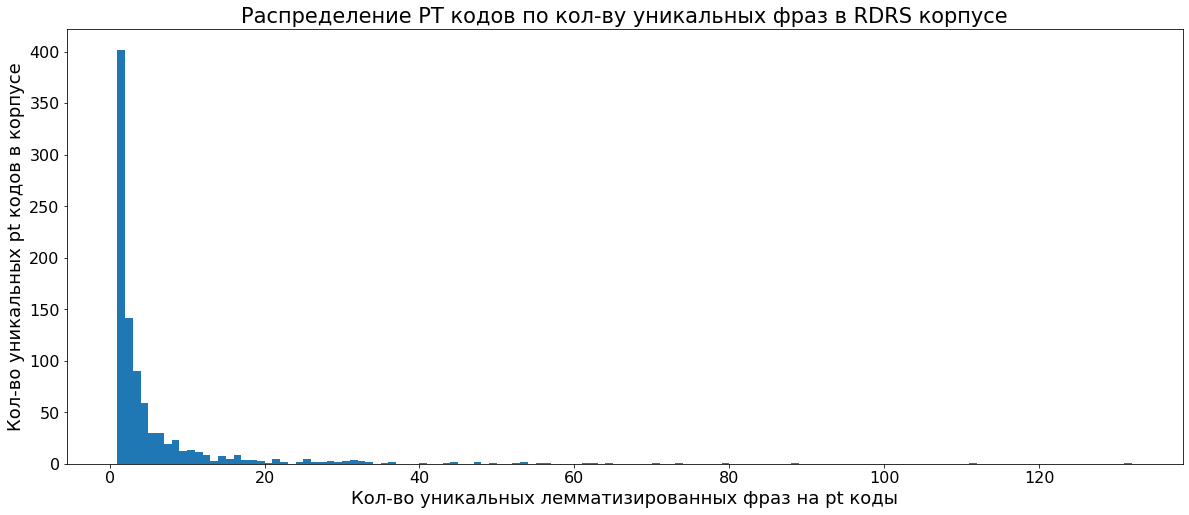

num uniq meddra codes: 936
num uniq phrases: 5103
avg num uniq phrases per code: 5.629273504273504


In [13]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           hist_fname='./Pictures/%s (with lemmatization).png'%corpus_name,
                           title = 'Распределение PT кодов по кол-ву уникальных фраз в %s корпусе'%corpus_name)
count_uniq_codes_and_phrases(stat_d)
avg_num_phrases_per_code(stat_d)

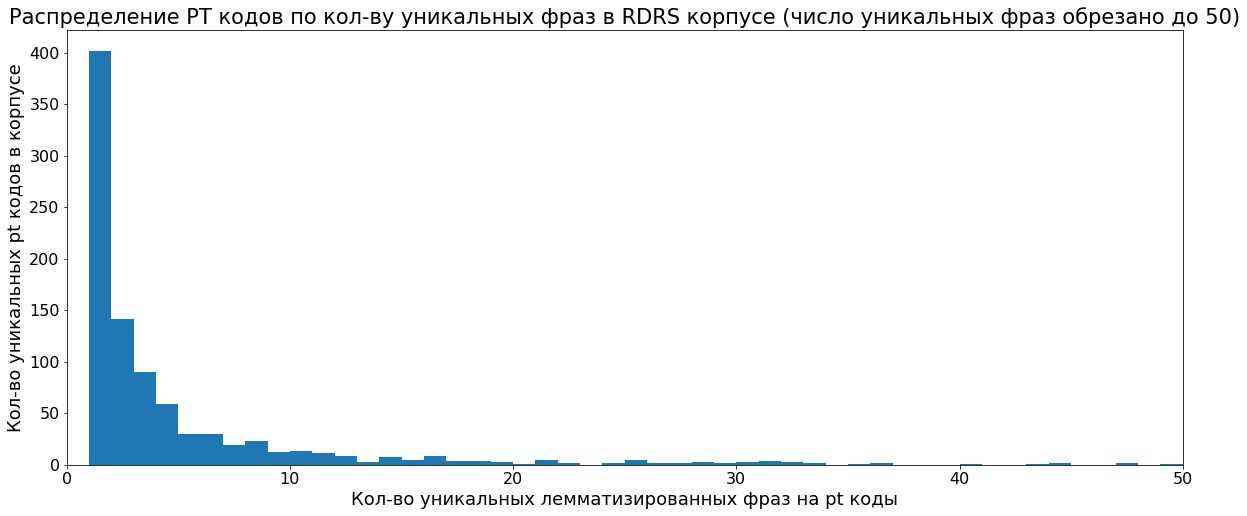

In [14]:
xlim_right = 50
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize = (20,8), \
                           xlim = (0, xlim_right), \
                           hist_fname='./Pictures/%s (with lemmatization) xlim_right %s.png'%(corpus_name, xlim_right), 
                           title = 'Распределение PT кодов по кол-ву уникальных фраз в %s корпусе (число уникальных фраз обрезано до %s)'%(corpus_name, xlim_right))

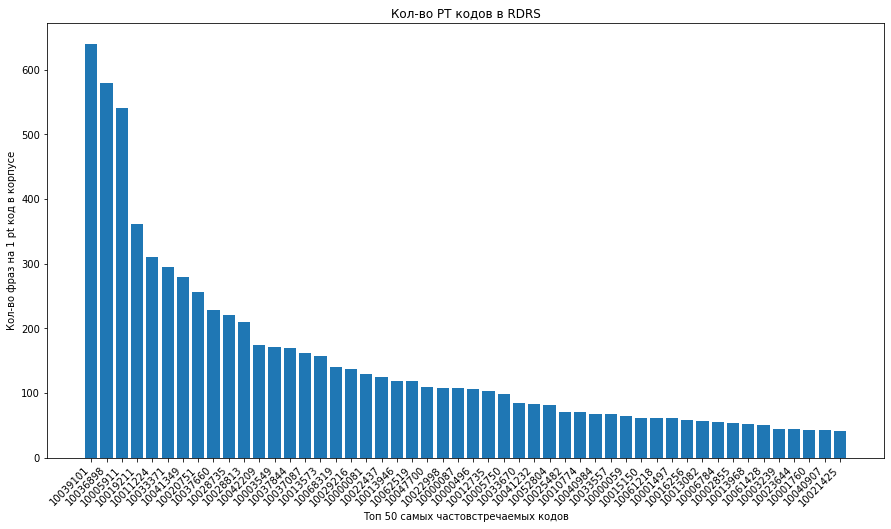

In [15]:
#сформируем статистику примеров
codes_count = Counter(all_pt_ids)
get_freq_codes_hist(codes_count, figsize=(15, 8), num_freq_codes=50, hist_fname='./Pictures/%s freq codes.png'%corpus_name, title='Кол-во PT кодов в %s'%corpus_name)

In [16]:
get_phrases_unambiguity_df(all_pt_ids, load_lemmas_li(cfg['corp_name'], cfg['lang']))

Кол-во уникальных кодов после лемматизации             \
                                                               1     2    3   
Кол-во фраз в корпусе                                      10087  1546  121   

                                   
                         4   5  6  
Кол-во фраз в корпусе  128  20  6

In [18]:
#среднее кол-во pt на в тексте
#[якорь] для удобного поиска
len_ds = len(ds)
avg_pt_in_text = len(all_pt_ids) / len_ds
#средняя длинна текста в токенах
print('tokenize texts')
num_ds_words = 0
for review in tqdm(ds):
    review_text = review['raw']
    num_ds_words+=len(tokenize_text(review_text, cfg))
avg_num_words_in_text = num_ds_words / len_ds
#средняя длина упоминания
print('tokenize phrases')
num_phrases_words = 0
for phrase in tqdm(all_pt_phrases):
    num_phrases_words+=len(tokenize_text(phrase, cfg))
avg_num_words_in_phrase = num_phrases_words/len(all_pt_phrases)
print('len ds: %s\navg pt in text: %s\navg num words in text: %s\navg num words in phrase: %s'%(len_ds, avg_pt_in_text, \
                                                       avg_num_words_in_text, \
                                                       avg_num_words_in_phrase,
                                                       ))

tokenize texts


100%|██████████| 3837/3837 [06:37<00:00,  9.65it/s]


tokenize phrases


100%|██████████| 11908/11908 [00:40<00:00, 292.30it/s]

len ds: 3837
avg pt in text: 3.1034662496742245
avg num words in text: 163.74511336982016
avg num words in phrase: 2.641165602955996


In [19]:
get_freq_codes_table(codes_count, num_freq_codes=50, lang='both', table_fname='./Tables/%s most freq codes.xlsx'%corpus_name)

,PT код,Название PT концепта,Кол-во примеров
1,10039101,Ринорея / Rhinorrhoea,640
2,10036898,Профилактика / Prophylaxis,579
3,10005911,Повышенная температура тела / Body temperature...,540
4,10019211,Головная боль / Headache,362
5,10011224,Кашель / Cough,311
6,10033371,Боль / Pain,295
7,10041349,Сомнолентность / Somnolence,280
8,10020751,Гиперчувствительность / Hypersensitivity,257
9,10037660,Пирексия / Pyrexia,228
10,10028735,Заложенность носа / Nasal congestion,221


<h4>Введем глобальную переменную с множеством PT кодов RDRs</h4>

In [20]:
RDRS_PT_IDS_SET = set(all_pt_ids)

<h4>Добавим датасет в единый набор данных</h4>

In [30]:
FULL_DS = concat_new_corp_to_ds(FULL_DS, all_pt_phrases, all_pt_ids, cfg['corp_name'], cfg['lang'])

<h4>Посмотрим статистку in and out of voc</h4>

In [32]:
X_train, X_test = train_test_split(ds, test_size=0.33, random_state=42)
train_concepts = []
test_concepts = []
for review in X_train:
    for ent in review['objects']['MedEntity']:
        if 'MedDRA' in ent.keys():
            if ent['MedDRA']=='':
                continue
            try:
                train_concepts.append(mh_rus.pt_to_ptcode[ent['MedDRA'].split('|')[0]])
            except KeyError:
                pass
            

for review in X_test:
    for ent in review['objects']['MedEntity']:
        if 'MedDRA' in ent.keys():
            if ent['MedDRA']=='':
                continue
            try:
                test_concepts.append(mh_rus.pt_to_ptcode[ent['MedDRA'].split('|')[0]])
            except KeyError:
                pass

In [33]:
get_out_of_voc_table(train_concepts, test_concepts)

Тестовое множество       Обучающее множество      
                Нет в тренировочном Всего      Нет в тестовом Всего
Кол-во примеров                 194  3787                 728  8121

<h3>CADEC</h3>

In [34]:
cfg = {'corp_name': 'CADEC',
       'lemmatize': True,
       'lang': 'en'}

corpus_name = cfg['corp_name']

<h4>Разбиение Stanovsky</h4>

In [35]:
#не используется в отчете
data_dir = './Raw/CADEC_Stanovsky/' 
ds_ids = {'train': [], 'test': []}    
for mode in ['train', 'test']:
    with open(data_dir + '%s_origin.encoded.conll'%mode) as f:
        for line in f:
            if line!='\n' and line.find('\t')<0:
                ds_ids[mode].append(line.strip('\n'))

In [36]:
ds_concepts = {'test': [], 'train': []}

all_pt_ids = []
all_pt_phrases = []
errors = 0
for mode in ['train', 'test']:
    for file_id in ds_ids[mode]:
        with open('./Raw/CADEC_Stanovsky/meddra/' + file_id + '.ann') as f:
            for line in f:
                if line=='\n':
                    continue
                try:
                    _, pt_id, pt_phrase = line.split('\t')
                except ValueError:
                    _, pt_id, pt_phrase = re.sub('\s\s+', '\t', line).split('\t')
                pt_id = pt_id.split(' ')[0]
                if pt_id in mh_en.lltcode_to_ptcode.keys():
                    pt_id = mh_en.lltcode_to_ptcode[pt_id]
                    all_pt_ids.append(pt_id)
                    all_pt_phrases.append(pt_phrase)
                    ds_concepts[mode].append(pt_id)
                elif pt_id in mh_en.ptcodes:
                    all_pt_ids.append(pt_id)
                    all_pt_phrases.append(pt_phrase)
                    ds_concepts[mode].append(pt_id)
                else:
                    errors+=1
stat_d = count_representativeness(all_pt_ids, all_pt_phrases, save_lemmas_li=True, **cfg)
if not CorpStat.check_saved_stat_for_corp(**cfg):
    stat_d.save_stat_for_corp()
test_concepts = ds_concepts['test']
train_concepts = ds_concepts['train']

100%|██████████| 5976/5976 [03:12<00:00, 31.07it/s]

saving corpus CADEC statistic, lang: en, lemmatize: True


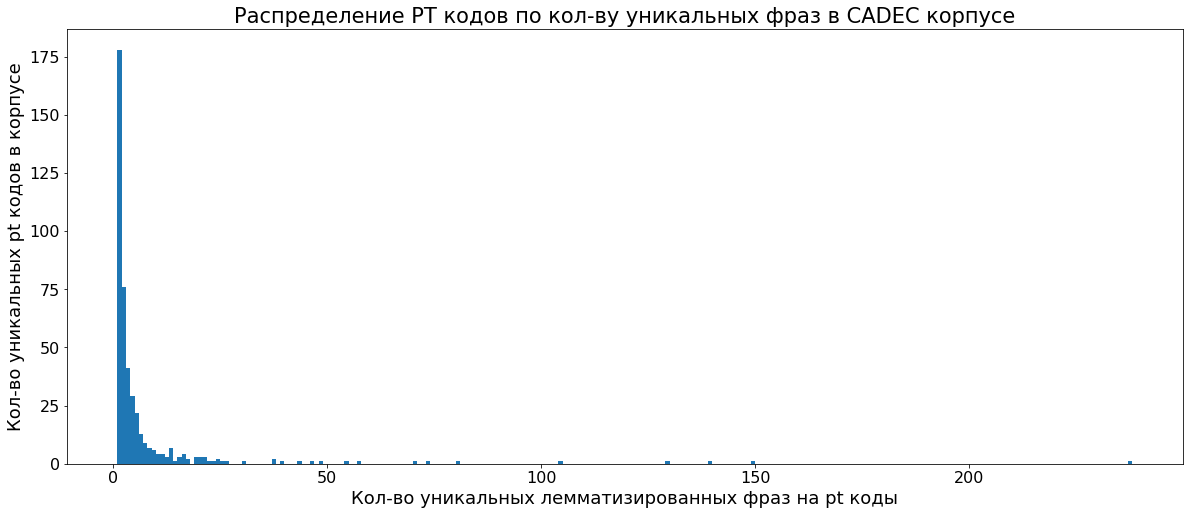

num uniq meddra codes: 441
num uniq phrases: 2981
avg num uniq phrases per code: 6.791383219954649


In [38]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           hist_fname='./Pictures/%s (with lemmatization).png'%corpus_name,
                           title = 'Распределение PT кодов по кол-ву уникальных фраз в %s корпусе'%corpus_name)
count_uniq_codes_and_phrases(stat_d)
avg_num_phrases_per_code(stat_d)

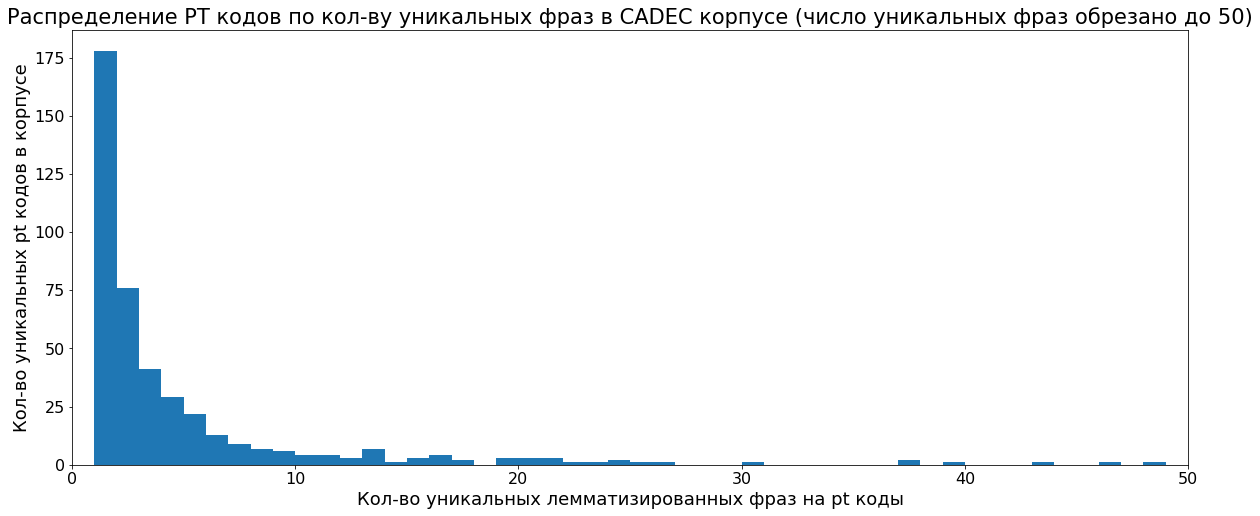

In [39]:
xlim_right = 50
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize = (20,8), \
                           xlim = (0, xlim_right), \
                           hist_fname='./Pictures/%s (with lemmatization) xlim_right %s.png'%(corpus_name, xlim_right), 
                           title = 'Распределение PT кодов по кол-ву уникальных фраз в %s корпусе (число уникальных фраз обрезано до %s)'%(corpus_name,xlim_right))

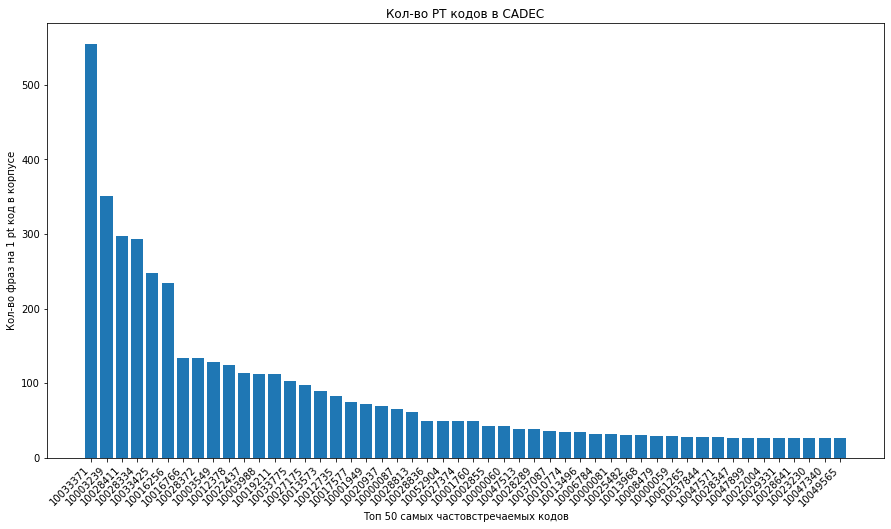

In [40]:
#сформируем статистику примеров
codes_count = Counter(all_pt_ids)
get_freq_codes_hist(codes_count, figsize=(15, 8), num_freq_codes=50, hist_fname='./Pictures/%s freq codes.png'%corpus_name, title='Кол-во PT кодов в %s'%corpus_name)

In [41]:
get_phrases_unambiguity_df(all_pt_ids, load_lemmas_li(cfg['corp_name'], cfg['lang']))

Кол-во уникальных кодов после лемматизации     
                                                               1    2
Кол-во фраз в корпусе                                       5831  145

In [44]:
#средняя длинна текста в токенах (цифры кол-ва слова из статьи по CADEC https://gabrielstanovsky.github.io/assets/papers/eacl17a/paper.pdf)
#[якорь] для удобного поиска
num_ds_words = 127834
len_ds = 1244
#среднее кол-во pt в тексте
avg_pt_in_text = len(all_pt_ids) / len_ds
#среднее кол-во слов в тексте
avg_num_words_in_text = num_ds_words / len_ds
#средняя длина упоминания
num_phrases_words = 0
print('tokenize phrases...')
for phrase in tqdm(all_pt_phrases):
    num_phrases_words+=len(tokenize_text(phrase, cfg['lang']))
avg_num_words_in_phrase = num_phrases_words/len(all_pt_phrases)
print('len ds: %s\navg pt in text: %s\navg num words in text: %s\navg num words in phrase: %s'%(len_ds, avg_pt_in_text, \
                                                       avg_num_words_in_text, \
                                                       avg_num_words_in_phrase,
                                                       ))

tokenize phrases...


100%|██████████| 5976/5976 [00:21<00:00, 279.24it/s]

len ds: 1244
avg pt in text: 4.803858520900322
avg num words in text: 102.76045016077171
avg num words in phrase: 2.603078982597055


In [45]:
get_freq_codes_table(codes_count, num_freq_codes=50, lang='both', table_fname='./Tables/%s most freq codes.xlsx'%corpus_name)

,PT код,Название PT концепта,Кол-во примеров
1,10033371,Боль / Pain,555
2,10003239,Артралгия / Arthralgia,351
3,10028411,Миалгия / Myalgia,297
4,10028334,Мышечные спазмы / Muscle spasms,293
5,10033425,Боль в конечности / Pain in extremity,248
6,10016256,Усталость / Fatigue,234
7,10016766,Флатуленция / Flatulence,134
8,10028372,Мышечная слабость / Muscular weakness,134
9,10003549,Астения / Asthenia,128
10,10012378,Депрессия / Depression,124


In [46]:
print('num codes in intersection with RDRS: %s'%len(set.intersection(set(all_pt_ids), RDRS_PT_IDS_SET)))

num codes in intersection with RDRS: 251


<h4>Разбиение Тутубалиной на 5 фолдов - по нему посчитаем outofvoc</h4>

In [47]:
#Оно по SNOMED и не используется
#data_dir = './Raw/CADEC_Tutubalina/'
#for mode in ['train', 'test']:
#    for fold in range(5):
#        df = pd.read_csv(data_dir+mode+'_'+str(fold)+'.csv', sep='\t')
#        df

In [48]:
get_out_of_voc_table(train_concepts, test_concepts)

Тестовое множество       Обучающее множество      
                Нет в тренировочном Всего      Нет в тестовом Всего
Кол-во примеров                  73  1413                 391  4563

<h4>То, что просил Сбоев</h4>

In [29]:
CADEC_diff = set(all_pt_ids) - set(RDRS_PT_IDS_SET)
mh_li = [mh_rus, mh_en]
pt_ids_li = list(CADEC_diff)
concept_name_li = [' / '.join([curr_mh.ptcode_to_pt[code] for curr_mh in mh_li]) for code in pt_ids_li]
diff_codes_table = pd.DataFrame({'PT код': pt_ids_li,
                                 'Название PT концепта': concept_name_li})
diff_codes_table.to_excel('./Tables/То,что есть в кадеке, но нет в RDRS.xlsx', index=False)
#diff_codes_table

In [50]:
FULL_DS = concat_new_corp_to_ds(FULL_DS, all_pt_phrases, all_pt_ids, cfg['corp_name'], cfg['lang'])

<h3>TAC 2017</h3>

In [52]:
#без контекста, только фразы c нормализацией
cfg = {'corp_name': 'TAC 2017',
       'lemmatize': True,
       'lang': 'en', 
       }


corpus_name = cfg['corp_name']



data_dir = './Raw/TAC 2017/train_xml'
num_ds_words = 0
len_ds = 0

def list_and_filter_dir(data_dir):
    for file in os.listdir(data_dir):
        if file[0]=='.' or file.find('xml')<0:
            continue
        yield file
        

all_pt_ids = []
all_pt_terms = []
all_pt_phrases = []

print('tokenize texts...')
for file in tqdm(list_and_filter_dir(data_dir)):
    len_ds+=1
    tree = ET.parse(os.path.join(data_dir, file))
    root = tree.getroot()
    
    pt_ids = []
    pt_terms = []
    pt_phrases = []
        
    for section in root.findall('./Text/Section'):
        num_ds_words += len(tokenize_text(section.text, cfg['lang']))
        
    for norm_mention in root.findall('./Reactions/Reaction'):
        for meddra_code in norm_mention.findall('Normalization'):
            meddra_pt = meddra_code.get('meddra_pt')
            meddra_pt_id = meddra_code.get('meddra_pt_id')
            meddra_llt_id = meddra_code.get('meddra_llt_id')
            if meddra_pt is None or (meddra_pt_id is None and meddra_llt_id is None):
                continue
            if meddra_llt_id:
                meddra_pt_id = mh_en.lltcode_to_ptcode[meddra_llt_id]
            pt_ids.append(meddra_pt_id)
            pt_terms.append(meddra_pt)
            pt_phrases.append(norm_mention.get('str'))
            
    all_pt_ids.extend(pt_ids)
    all_pt_terms.extend(pt_terms)
    all_pt_phrases.extend(pt_phrases)
    
#print(all_pt_ids[500:508])
#print(all_pt_terms[500:508])
#print(all_pt_phrases[500:508])

stat_d = count_representativeness(all_pt_ids, all_pt_phrases, save_lemmas_li=True, **cfg)
if not CorpStat.check_saved_stat_for_corp(**cfg):
    stat_d.save_stat_for_corp()
stat_d = {k: v for k, v in stat_d.items() if k in mh_en.ptcodes}
#pprint(stat_d)

tokenize texts...


101it [00:46,  2.18it/s]
100%|██████████| 7045/7045 [04:29<00:00, 26.16it/s]


saving corpus TAC 2017 statistic, lang: en, lemmatize: True


In [ ]:
stat_d = CorpStat.load_stat_for_corp(**cfg)
stat_d_filtered = {k: v for k, v in stat_d.map_codes_to_phrases.items() if k in mh_en.ptcodes}
stat_d = CorpStat(stat_d_filtered)
stat_d

In [53]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 7045


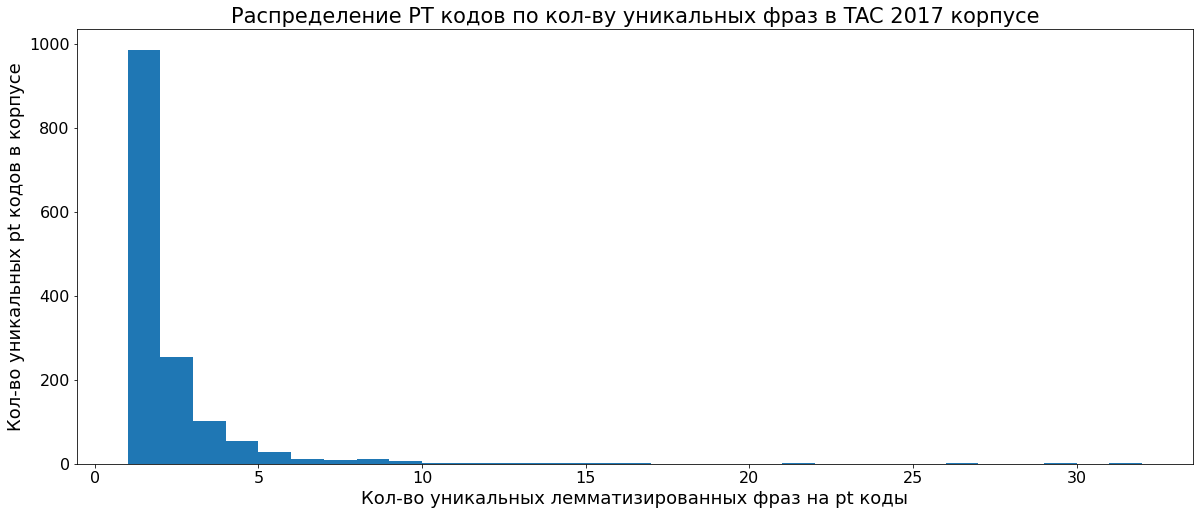

num uniq meddra codes: 1482
num uniq phrases: 2705
avg num uniq phrases per code: 1.8535762483130904


In [57]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           hist_fname='./Pictures/%s (with lemmatization).png'%corpus_name,
                           title = 'Распределение PT кодов по кол-ву уникальных фраз в %s корпусе'%corpus_name)
count_uniq_codes_and_phrases(stat_d)
avg_num_phrases_per_code(stat_d)

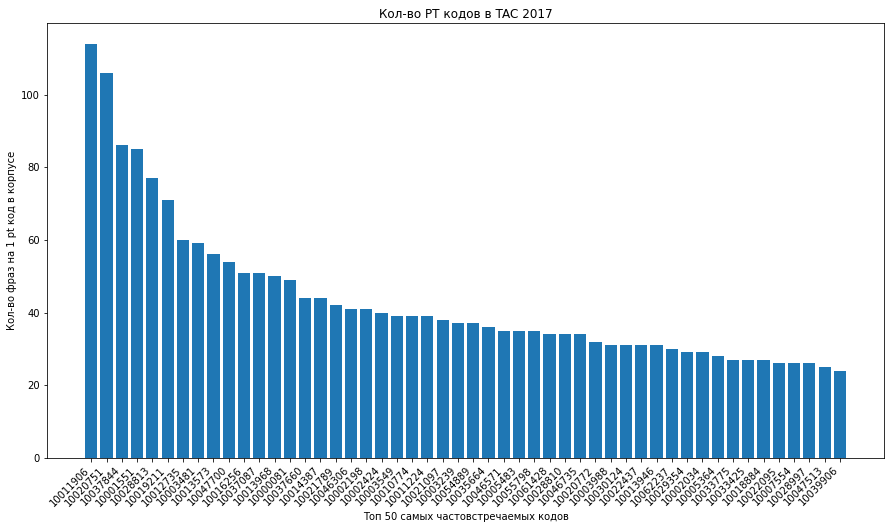

In [58]:
#сформируем статистику примеров
codes_count = Counter(all_pt_ids)
get_freq_codes_hist(codes_count, figsize=(15, 8), num_freq_codes=50, hist_fname='./Pictures/%s freq codes.png'%corpus_name, title='Кол-во PT кодов в %s'%corpus_name)

In [59]:
get_phrases_unambiguity_df(all_pt_ids, load_lemmas_li(cfg['corp_name'], cfg['lang']))

Кол-во уникальных кодов после лемматизации     
                                                               1    2
Кол-во фраз в корпусе                                       6943  102

In [60]:
get_freq_codes_table(codes_count, num_freq_codes=50, table_fname='./Tables/%s most freq codes.xlsx'%corpus_name)

,PT код,Название PT концепта,Кол-во примеров
1,10011906,Смерть,114
2,10020751,Гиперчувствительность,106
3,10037844,Сыпь,86
4,10001551,Повышение уровня аланинаминотрансферазы,85
5,10028813,Тошнота,77
6,10019211,Головная боль,71
7,10012735,Диарея,60
8,10003481,Повышение уровня аспартатаминотрансферазы,59
9,10013573,Головокружение,56
10,10047700,Рвота,54


In [63]:
#среднее кол-во pt в тексте
#[якорь] для удобного поиска
avg_pt_in_text = len(all_pt_ids) / len_ds
#среднее кол-во слов в тексте
avg_num_words_in_text = num_ds_words / len_ds
#средняя длина упоминания
num_phrases_words = 0
print('tokenize phrases...')
for phrase in tqdm(all_pt_phrases):
    num_phrases_words+=len(tokenize_text(phrase, cfg['lang']))
avg_num_words_in_phrase = num_phrases_words/len(all_pt_phrases)
print('len ds: %s\navg pt in text: %s\navg num words in text: %s\navg num words in phrase: %s'%(len_ds, avg_pt_in_text, \
                                                       avg_num_words_in_text, \
                                                       avg_num_words_in_phrase,
                                                       ))


tokenize phrases...


100%|██████████| 7045/7045 [00:25<00:00, 281.07it/s]

len ds: 101
avg pt in text: 69.75247524752476
avg num words in text: 2611.2178217821784
avg num words in phrase: 2.000567778566359


In [36]:
#насколько множество pt кодов совпадает с нашим корпусом RDR?

In [64]:
print('num codes in intersection with RDRS: %s'%len(set.intersection(set(all_pt_ids), RDRS_PT_IDS_SET)))

num codes in intersection with RDRS: 422


In [65]:
FULL_DS = concat_new_corp_to_ds(FULL_DS, all_pt_phrases, all_pt_ids, cfg['corp_name'], cfg['lang'])

<h3>SMM4H 2017</h3>

In [67]:
cfg = {'corp_name': 'SMM4H 2017',
       'lemmatize': True,
       'lang': 'en', 
       }


corpus_name = cfg['corp_name']


corpus_name = 'SMM4H 2017'
data_dir = './Raw/SMM4H_2017/'
ds_ids = set()
with open(data_dir + 'train.txt') as tr, open(data_dir + 'test.txt') as ts:
    train_phrases = []
    train_terms = []
    train_codes = []
    test_phrases = []
    test_terms = []
    test_codes = []
    for pair in tr.read().split('\n'):
        if pair=='':
            continue
        row_inf = pair.split('\t')
        if row_inf[2] in mh_en.lltcode_to_ptcode.keys():
            row_inf[2] = mh_en.lltcode_to_ptcode[row_inf[2]]
        if row_inf[2] in mh_en.ptcodes:
            train_phrases.append(row_inf[1])
            train_terms.append(mh_en.ptcode_to_pt[row_inf[2]])
            train_codes.append(row_inf[2])
        ds_ids.add(row_inf[0])
    for pair in ts.read().split('\n'):
        if pair=='':
            continue
        row_inf = pair.split('\t')
        if row_inf[2] in mh_en.lltcode_to_ptcode.keys():
            row_inf[2] = mh_en.lltcode_to_ptcode[row_inf[2]]
        if row_inf[2] in mh_en.ptcodes:
            test_phrases.append(row_inf[1])
            test_terms.append(mh_en.ptcode_to_pt[row_inf[2]])
            test_codes.append(row_inf[2])
        ds_ids.add(row_inf[0])
        
all_pt_ids = train_codes + test_codes
all_pt_phrases = train_phrases + test_phrases
stat_d = count_representativeness(all_pt_ids, all_pt_phrases, save_lemmas_li=True, **cfg)
if not CorpStat.check_saved_stat_for_corp(**cfg):
    stat_d.save_stat_for_corp()
len_ds = len(ds_ids)

100%|██████████| 9139/9139 [04:21<00:00, 34.97it/s]

saving corpus SMM4H 2017 statistic, lang: en, lemmatize: True


In [70]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 9139


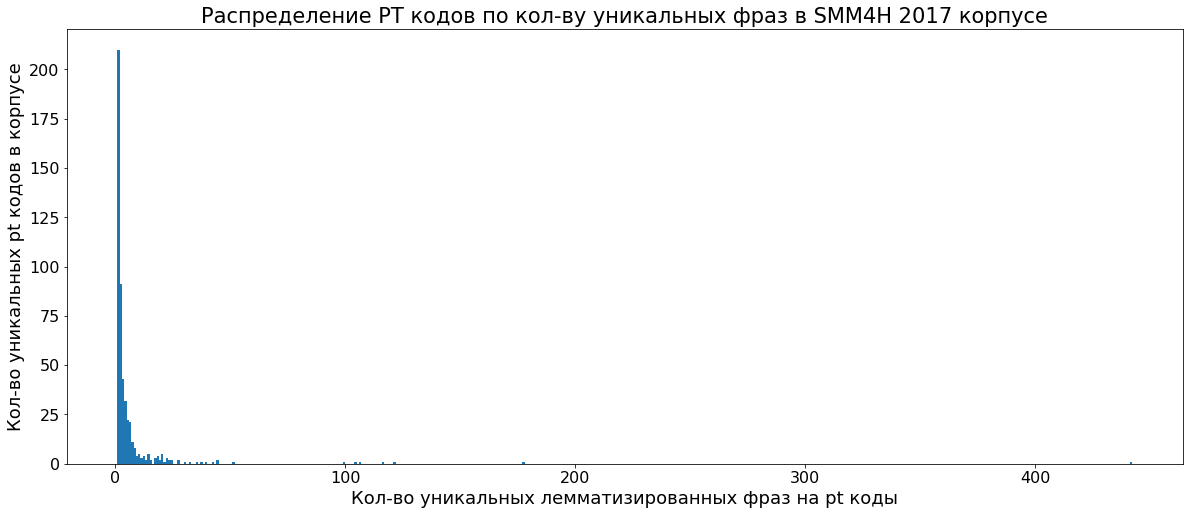

num uniq meddra codes: 503
num uniq phrases: 3312
avg num uniq phrases per code: 6.6282306163021865


In [71]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           hist_fname='./Pictures/%s (with lemmatization).png'%corpus_name,
                           title = 'Распределение PT кодов по кол-ву уникальных фраз в %s корпусе'%corpus_name)
count_uniq_codes_and_phrases(stat_d)
avg_num_phrases_per_code(stat_d)

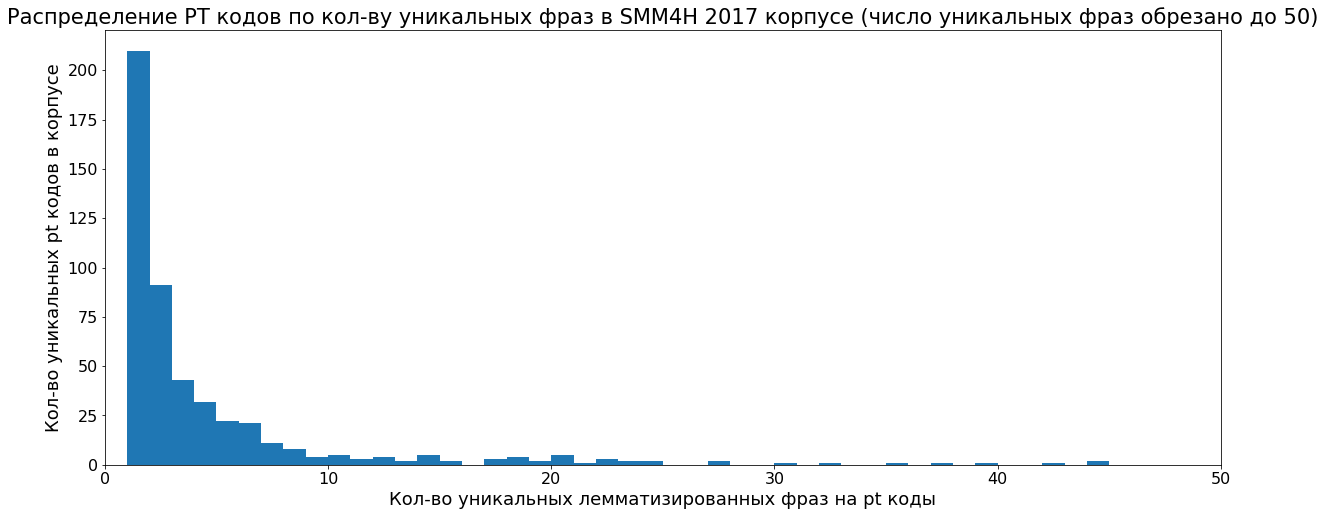

In [72]:
xlim_right = 50
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize = (20,8), \
                           xlim = (0, xlim_right), \
                           hist_fname='./Pictures/%s (with lemmatization) xlim_right %s.png'%(corpus_name, xlim_right), 
                           title = 'Распределение PT кодов по кол-ву уникальных фраз в %s корпусе (число уникальных фраз обрезано до %s)'%(corpus_name,xlim_right))

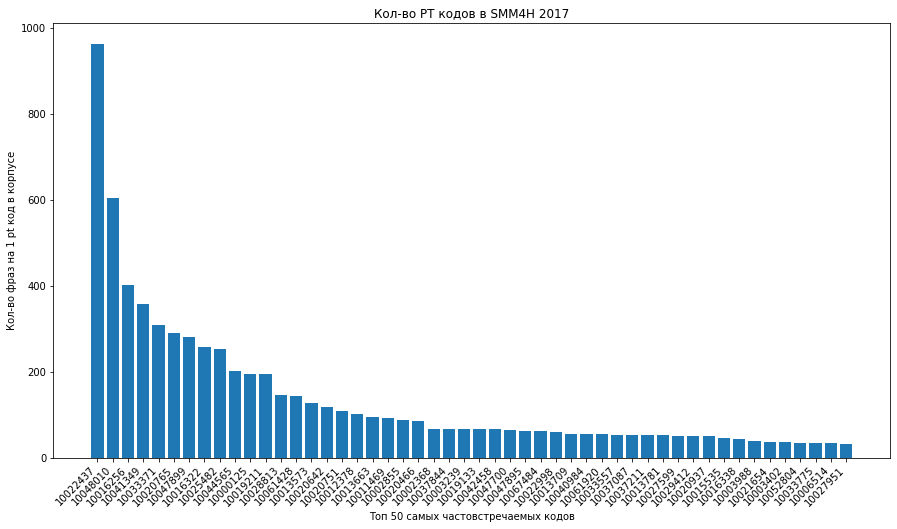

In [73]:
#сформируем статистику примеров
codes_count = Counter(all_pt_ids)
get_freq_codes_hist(codes_count, figsize=(15, 8), num_freq_codes=50, hist_fname='./Pictures/%s freq codes.png'%corpus_name, title='Кол-во PT кодов в %s'%corpus_name)

In [74]:
get_phrases_unambiguity_df(all_pt_ids, load_lemmas_li(cfg['corp_name'], cfg['lang']))

Кол-во уникальных кодов после лемматизации     
                                                               1    2
Кол-во фраз в корпусе                                       8962  177

In [75]:
get_freq_codes_table(codes_count, num_freq_codes=50, lang='both', table_fname='./Tables/%s most freq codes.xlsx'%corpus_name)

,PT код,Название PT концепта,Кол-во примеров
1,10022437,Бессонница / Insomnia,963
2,10048010,Абстинентный синдром / Withdrawal syndrome,605
3,10016256,Усталость / Fatigue,401
4,10041349,Сомнолентность / Somnolence,357
5,10033371,Боль / Pain,308
6,10020765,Гиперсомния / Hypersomnia,291
7,10047899,Увеличение веса / Weight increased,282
8,10016322,Плохое самочувствие / Feeling abnormal,257
9,10025482,Недомогание / Malaise,252
10,10044565,Тремор / Tremor,203


In [78]:
#среднее кол-во pt в тексте
#[якорь] для удобного поиска
avg_pt_in_text = len(all_pt_ids) / len_ds
#среднее кол-во слов в тексте
#avg_num_words_in_text = num_ds_words / len_ds
#средняя длина упоминания
num_phrases_words = 0
print('tokenize phrases...')
for phrase in tqdm(all_pt_phrases):
    num_phrases_words+=len(tokenize_text(phrase, cfg['lang']))
avg_num_words_in_phrase = num_phrases_words/len(all_pt_phrases)
print('len ds: %s\navg pt in text: %s\navg num words in text: %s\navg num words in phrase: %s'%(len_ds, avg_pt_in_text, \
                                                       avg_num_words_in_text, \
                                                       avg_num_words_in_phrase,
                                                       ))


tokenize phrases...


100%|██████████| 9139/9139 [00:28<00:00, 320.25it/s]

len ds: 9149
avg pt in text: 0.9989069843698765
avg num words in text: 2611.2178217821784
avg num words in phrase: 2.0762665499507604


In [79]:
get_out_of_voc_table(train_codes, test_codes)

Тестовое множество       Обучающее множество      
                Нет в тренировочном Всего      Нет в тестовом Всего
Кол-во примеров                  36  2496                 582  6643

In [80]:
print('num codes in intersection with RDRS: %s'%len(set.intersection(set(all_pt_ids), RDRS_PT_IDS_SET)))

num codes in intersection with RDRS: 284


In [81]:
FULL_DS = concat_new_corp_to_ds(FULL_DS, all_pt_phrases, all_pt_ids, cfg['corp_name'], cfg['lang'])

<h3>MedMention</h3>

In [84]:
cfg = {'corp_name': 'MedMention',
       'lemmatize': True,
       'lang': 'en', 
       }

corpus_name=cfg['corp_name']

data_dir = './Raw/MedMentions/full/data/'
num_ds_words = 0

test_concepts = []
train_concepts = []
test_phrases = []
train_phrases = []

all_txt_ids = []
all_pt_ids = []
all_pt_phrases = []

no_matched_umls_codes = []

with open(data_dir+'corpus_pubtator_pmids_test.txt') as f:
    test_ids = f.read().strip('\n').split('\n')
    
with open(data_dir+'corpus_pubtator_pmids_trng.txt') as f:
    train_ids = f.read().strip('\n').split('\n')

len_ds = len(test_ids) + len(train_ids)
    
with open(data_dir+'corpus_pubtator.txt') as f:
    print('tokenize texts...')
    for line in tqdm(f, total=len_ds):
        if line.find('|')>0:
            num_ds_words+=len(tokenize_text(line.split('|')[2], cfg['lang']))
            continue
        if line=='\n':
            continue
        row_inf = line.split('\t')
        umls_id = row_inf[-1][:-1]
        curr_text_id = row_inf[0]
        phrase = row_inf[3]
        pt_code = mh_en.force_umlscode_to_ptcode(umls_id)
        if pt_code and pt_code in mh_en.ptcodes:
            all_pt_ids.append(pt_code)
        else:
            no_matched_umls_codes.append(umls_id)
            continue
        if curr_text_id in test_ids:
            test_concepts.append(pt_code)
        elif curr_text_id in train_ids:
            train_concepts.append(pt_code)
        all_pt_phrases.append(phrase)
        all_txt_ids.append(curr_text_id)

len_ds = len(set(all_txt_ids))

tokenize texts...


365672it [13:26, 453.36it/s]                        


In [85]:
print('len no matched umls codes: %s'%len(no_matched_umls_codes))
print('len matched umls codes: %s'%len(all_pt_phrases))
#если использовать только pt коды, то len no matched umls codes: 322985

len no matched umls codes: 316341
len matched umls codes: 36155


In [86]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 36155


In [87]:
len(mh_en.umlscode_to_ptcode)

22759

In [88]:
stat_d = count_representativeness(all_pt_ids, all_pt_phrases, save_lemmas_li = True, **cfg)
if not CorpStat.check_saved_stat_for_corp(**cfg):
    stat_d.save_stat_for_corp()

100%|██████████| 36155/36155 [20:55<00:00, 28.80it/s]


saving corpus MedMention statistic, lang: en, lemmatize: True


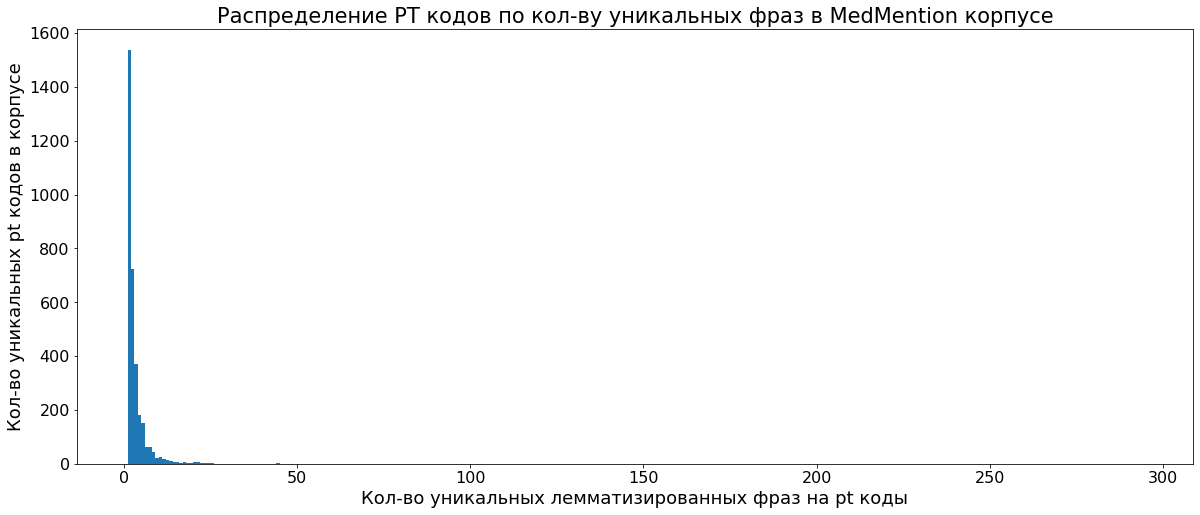

num uniq meddra codes: 3284
num uniq phrases: 9111
avg num uniq phrases per code: 2.922655298416565


In [95]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           hist_fname='./Pictures/%s (with lemmatization).png'%corpus_name,
                           title = 'Распределение PT кодов по кол-ву уникальных фраз в %s корпусе'%corpus_name)
count_uniq_codes_and_phrases(stat_d)
avg_num_phrases_per_code(stat_d)

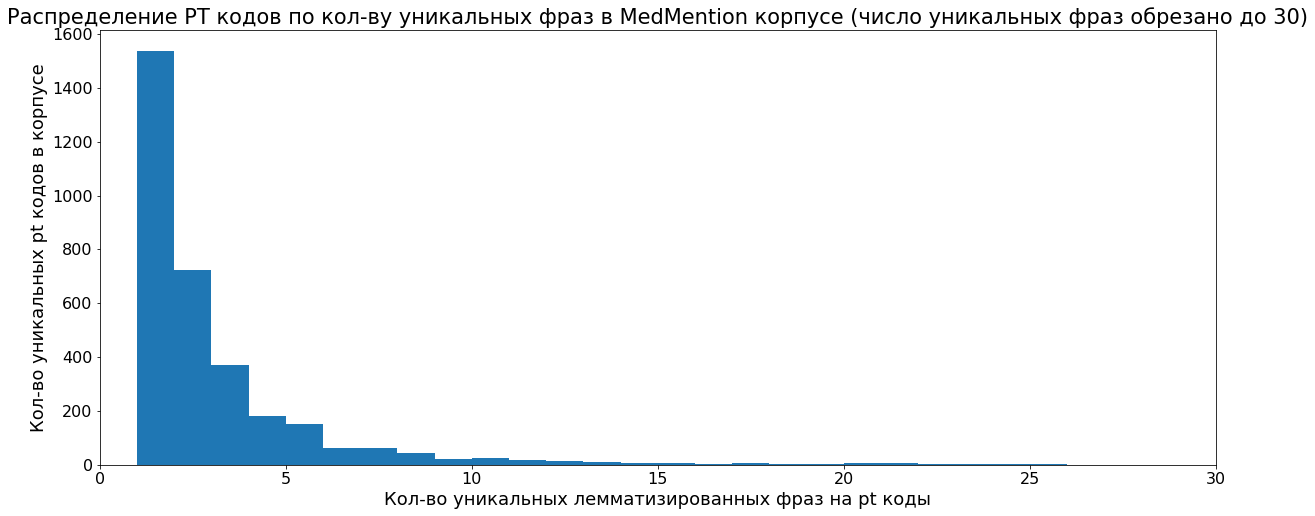

In [96]:
xlim_right = 30
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize = (20,8), \
                           xlim = (0, xlim_right), \
                           hist_fname='./Pictures/%s (with lemmatization) xlim_right %s.png'%(corpus_name, xlim_right), 
                           title = 'Распределение PT кодов по кол-ву уникальных фраз в %s корпусе (число уникальных фраз обрезано до %s)'%(corpus_name,xlim_right))

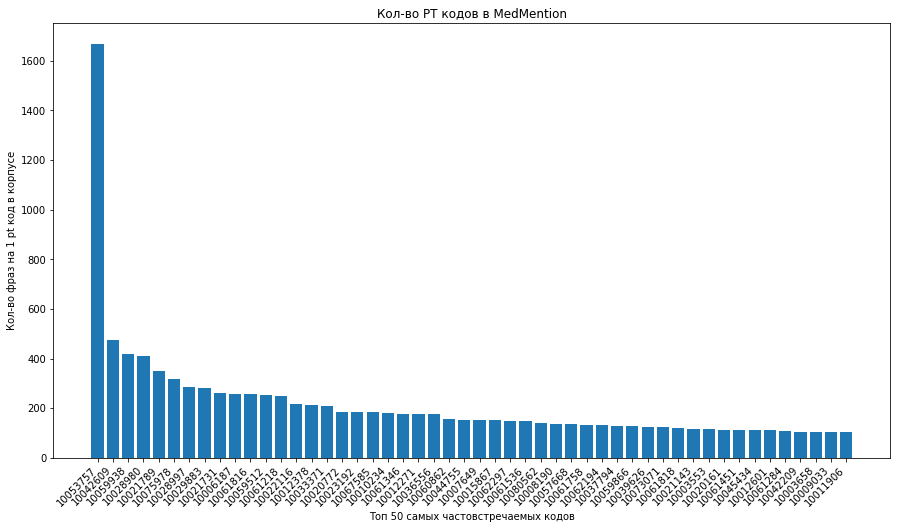

In [97]:
#сформируем статистику примеров
codes_count = Counter(all_pt_ids)
get_freq_codes_hist(codes_count, figsize=(15, 8), num_freq_codes=50, hist_fname='./Pictures/%s freq codes.png'%corpus_name, title='Кол-во PT кодов в %s'%corpus_name)

In [98]:
get_phrases_unambiguity_df(all_pt_ids, load_lemmas_li(cfg['corp_name'], cfg['lang']))

Кол-во уникальных кодов после лемматизации              \
                                                              1     2     3    
Кол-во фраз в корпусе                                      27862  5271  1328   

                                                       
                        4    5    6  7    8   13   14  
Кол-во фраз в корпусе  836  100  288  9  325  19  117

In [99]:
get_freq_codes_table(codes_count, lang='both', num_freq_codes=50, table_fname='./Tables/%s most freq codes.xlsx'%corpus_name)

,PT код,Название PT концепта,Кол-во примеров
1,10053757,Терапевтическая процедура / Therapeutic procedure,1669
2,10042609,Оперативное лечение / Surgery,476
3,10059938,Лабораторный анализ / Laboratory test,417
4,10028980,Новообразование / Neoplasm,410
5,10021789,Инфекция / Infection,351
6,10075978,Интервенционная процедура / Interventional pro...,319
7,10028997,Злокачественное новообразование / Neoplasm mal...,287
8,10029883,Ожирение / Obesity,282
9,10021731,Младенческий возраст / Infant,261
10,10006187,Рак молочной железы / Breast cancer,258


In [100]:
#среднее кол-во pt в тексте
#[якорь] для удобного поиска
avg_pt_in_text = len(all_pt_ids) / len_ds
#среднее кол-во слов в тексте
avg_num_words_in_text = num_ds_words / len_ds
#средняя длина упоминания
num_phrases_words = 0
print('tokenize phrases...')
for phrase in tqdm(all_pt_phrases):
    num_phrases_words+=len(tokenize_text(phrase, cfg['lang']))
avg_num_words_in_phrase = num_phrases_words/len(all_pt_phrases)
print('len ds: %s\navg pt in text: %s\navg num words in text: %s\navg num words in phrase: %s'%(len_ds, avg_pt_in_text, \
                                                       avg_num_words_in_text, \
                                                       avg_num_words_in_phrase,
                                                       ))

tokenize phrases...


100%|██████████| 36155/36155 [01:53<00:00, 318.87it/s]

len ds: 3577
avg pt in text: 10.107632093933464
avg num words in text: 335.0581492871121
avg num words in phrase: 1.5769879684690915


In [101]:
get_out_of_voc_table(train_concepts, test_concepts)

Тестовое множество       Обучающее множество       
                Нет в тренировочном Всего      Нет в тестовом  Всего
Кол-во примеров                1096  7022                6509  22031

In [102]:
FULL_DS = concat_new_corp_to_ds(FULL_DS, all_pt_phrases, all_pt_ids, cfg['corp_name'], cfg['lang'])

<h3>PsyTar origin (из коробки, без моей обработки и токенизации)</h3>

In [104]:
cfg = {'corp_name': 'PsyTar',
       'lemmatize': True,
       'lang': 'en', 
       }

corpus_name=cfg['corp_name']


df = pd.read_excel("./Raw/PsyTAR_origin/PsyTAR_dataset.xlsx", sheet_name=None, engine='openpyxl')
df = {'ADRs': df['ADR_Mapped'], 'WDs': df['WD-Mapped '], 'SSI': df['SSI_Mapped'], 'DIs': df['DI_Mapped']}

In [105]:
all_pt_ids = []
all_pt_phrases = []


for k in df:
    #df[k] = df[k].apply(lambda x: re.sub('\s+', '', x[x.name].split('/')[0]) if x.name == 'UMLS1' or x.name == 'UMLS2' else x)
    df[k]['UMLS1'] = df[k]['UMLS1'].apply(lambda x: re.sub('\s+', '', x.split('/')[0].upper()))
    df[k]['UMLS2'] = df[k]['UMLS2'].apply(lambda x: re.sub('\s+', '', x.split('/')[0].upper()) if pd.notna(x) else x)
    #из двух umls выбираем тот, у которого есть pt код
    df[k]['UMLS'] = df[k]['UMLS1']
    mask_no_pt_codes = df[k]['UMLS1'].apply(lambda x: False if mh_en.force_umlscode_to_ptcode(x) else True)
    #заменили на UMLS2 у которого может быть pt code, если UMLS2 нет, тогда ставится NaN
    df[k].loc[mask_no_pt_codes, 'UMLS'] = df[k]['UMLS2'][mask_no_pt_codes]
    df[k]['pt_meddra'] = df[k]['UMLS'].apply(lambda x: mh_en.force_umlscode_to_ptcode(x))
    df[k] = df[k][df[k]['pt_meddra'].notna()]
    pt_ids = df[k]['pt_meddra'].to_list()
    phrases_li = df[k][k].to_list()
    
    all_pt_phrases.extend(phrases_li)
    all_pt_ids.extend(pt_ids)
    
print(all_pt_phrases[700:710])
print(all_pt_ids[700:710])
print([mh_en.ptcode_to_pt[code] for code in all_pt_ids[700:710]])

['some sleepiness ', 'excessive yawning', 'at first, headache', 'at first, nausea', 'at first, trembling belly', 'at first, loss of appetite', 'vivid dreams ', 'nightmares', 'libido is low', 'low sex drive']
['10022437', '10048232', '10019211', '10028813', '10000059', '10061428', '10000125', '10029412', '10024419', '10024419']
['Insomnia', 'Yawning', 'Headache', 'Nausea', 'Abdominal discomfort', 'Decreased appetite', 'Abnormal dreams', 'Nightmare', 'Libido decreased', 'Libido decreased']


In [106]:
stat_d = count_representativeness(all_pt_ids, all_pt_phrases, save_lemmas_li=True, **cfg)
if not CorpStat.check_saved_stat_for_corp(**cfg):
    stat_d.save_stat_for_corp()

100%|██████████| 6300/6300 [03:08<00:00, 33.49it/s]

saving corpus PsyTar statistic, lang: en, lemmatize: True


In [107]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 6300


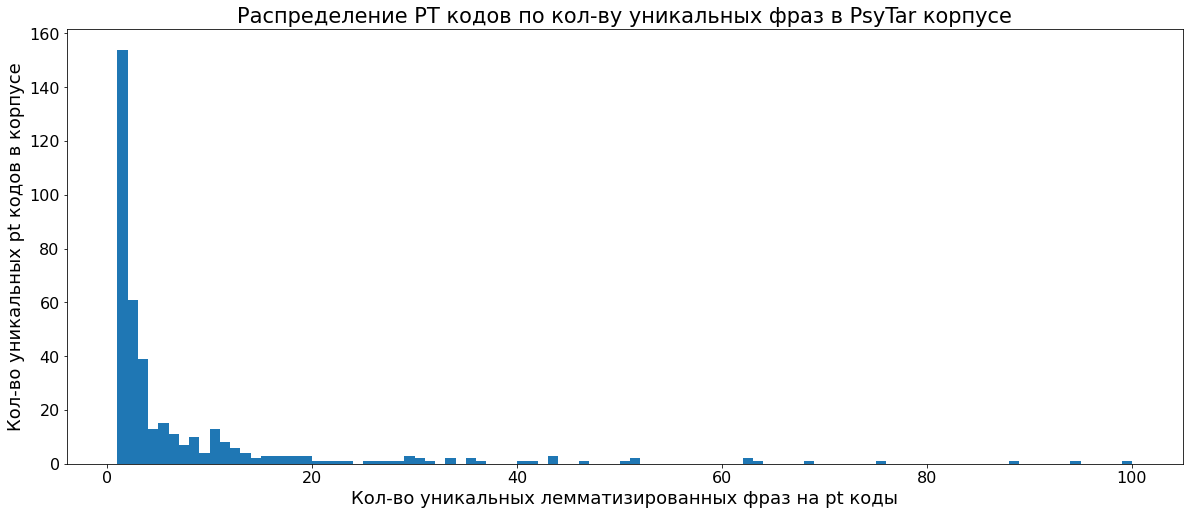

num uniq meddra codes: 398
num uniq phrases: 2916
avg num uniq phrases per code: 7.381909547738694


In [108]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           hist_fname='./Pictures/%s (with lemmatization).png'%corpus_name,
                           title = 'Распределение PT кодов по кол-ву уникальных фраз в %s корпусе'%corpus_name)
count_uniq_codes_and_phrases(stat_d)
avg_num_phrases_per_code(stat_d)

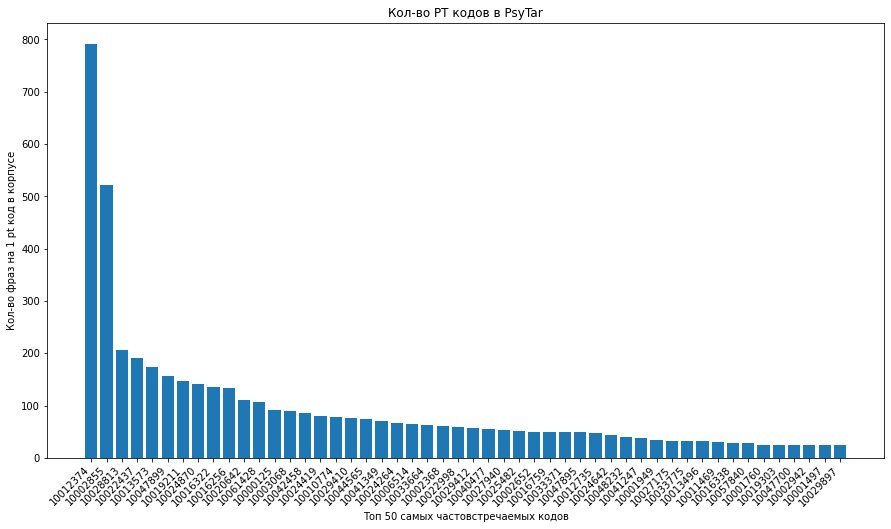

In [109]:
#сформируем статистику примеров
codes_count = Counter(all_pt_ids)
get_freq_codes_hist(codes_count, figsize=(15, 8), num_freq_codes=50, hist_fname='./Pictures/%s freq codes.png'%corpus_name, title='Кол-во PT кодов в %s'%corpus_name)

In [110]:
get_phrases_unambiguity_df(all_pt_ids, load_lemmas_li(cfg['corp_name'], cfg['lang']))

Кол-во уникальных кодов после лемматизации          
                                                               1    2    3
Кол-во фраз в корпусе                                       5593  152  555

In [112]:
#среднее кол-во pt в тексте
#[якорь] для удобного поиска
len_ds = 891 #(из статьи)
avg_pt_in_text = len(all_pt_ids) / len_ds
#среднее кол-во слов в тексте
#avg_num_words_in_text = num_ds_words / len_ds
#средняя длина упоминания
num_phrases_words = 0
print('tokenize phrases...')
for phrase in tqdm(all_pt_phrases):
    num_phrases_words+=len(tokenize_text(phrase, cfg['lang']))
avg_num_words_in_phrase = num_phrases_words/len(all_pt_phrases)
print('len ds: %s\navg pt in text: %s\navg num words in text: %s\navg num words in phrase: %s'%(len_ds, avg_pt_in_text, \
                                                       avg_num_words_in_text, \
                                                       avg_num_words_in_phrase,
                                                       ))


tokenize phrases...


100%|██████████| 6300/6300 [00:26<00:00, 241.23it/s]

len ds: 891
avg pt in text: 7.070707070707071
avg num words in text: 335.0581492871121
avg num words in phrase: 2.5490476190476192


In [113]:
get_freq_codes_table(codes_count, lang='both', num_freq_codes=50, table_fname='./Tables/%s most freq codes.xlsx'%corpus_name)

,PT код,Название PT концепта,Кол-во примеров
1,10012374,Сниженное настроение / Depressed mood,792
2,10002855,Чувство тревоги / Anxiety,522
3,10028813,Тошнота / Nausea,206
4,10022437,Бессонница / Insomnia,190
5,10013573,Головокружение / Dizziness,174
6,10047899,Увеличение веса / Weight increased,156
7,10019211,Головная боль / Headache,146
8,10024870,Отсутствие либидо / Loss of libido,142
9,10016322,Плохое самочувствие / Feeling abnormal,135
10,10016256,Усталость / Fatigue,134


In [115]:
print('num codes in intersection with RDRS: %s'%len(set.intersection(set(all_pt_ids), RDRS_PT_IDS_SET)))

num codes in intersection with RDRS: 229


In [116]:
FULL_DS = concat_new_corp_to_ds(FULL_DS, all_pt_phrases, all_pt_ids, cfg['corp_name'], cfg['lang'])

---

<h2>Работа с полным корпусом</h2>

1. v1 - FULL_prepared_corp.csv - отфильтрованы аббревиатуры из переведенной части
2. v2 - FULL_prepared_filtered_(3 word)\_hlt_corp.csv - отфильтрованы слова с длиной до 3 из переведенной части и аббревиатуры, добавлен уровень hlt
3. v3 - FULL_prepared_hlt_corp.csv - отфильтрованы аббревиатуры, добавлен уровень hlt

In [118]:
FULL_DS.to_csv('./CorpsStatisticData/FULL_normalization_corpus.csv', index=False)

In [122]:
FULL_DS['pt code'].nunique()

4607

In [125]:
print('num codes in intersection with RDRS: %s'%len(set.intersection(set(FULL_DS[FULL_DS['corp_name']!='RDRS']['pt code'].unique()), RDRS_PT_IDS_SET)))

num codes in intersection with RDRS: 641


1. Оставляем только en часть, переводим её
2. Добавляем llt с линком к pt
3. Оставляем только уникальные фразы

In [1]:
from googletrans import Translator
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

1#
FULL_DS = pd.read_csv('./CorpsStatisticData/FULL_normalization_corpus1.csv')
def translate(phrase):
    try:
        return translator.translate(phrase, src='en', dest='ru').text
    except:
        return 'no_translation'
    
translator = Translator()
FULL_DS_EN = FULL_DS[FULL_DS['lang']=='en'].reset_index(drop=True)
FULL_DS_EN['phrase_translated'] = FULL_DS_EN['phrase'].progress_apply(translate)
FULL_DS_EN

100%|██████████| 64615/64615 [7:06:10<00:00,  2.53it/s]   


,phrase,pt code,corp_name,lang,phrase_translated
0,pain in joints\n,10003239,CADEC,en,боль в суставах
1,pain in my left leg\n,10033425,CADEC,en,боль в моей левой ноге
2,Elevated CPK levels\n,10005483,CADEC,en,Повышенные уровни CPK
3,muscle problems\n,10028641,CADEC,en,мышечные проблемы
4,elevated CPK levels\n,10005483,CADEC,en,повышенные уровни CPK
...,...,...,...,...,...
64610,anxiety,10002855,PsyTar,en,no_translation
64611,stress,10042209,PsyTar,en,стресс
64612,jump off the deap end,10029901,PsyTar,en,no_translation
64613,depression,10012374,PsyTar,en,no_translation


In [2]:
FULL_DS_EN.to_csv('./CorpsStatisticData/FULL_normalization_corpus_translated_part1.csv', index=False)

In [54]:
from googletrans import Translator
import pandas as pd
from tqdm import tqdm
import re
    
regex = r'[AZ][AZ]+'
def filter_abbreviation_rows(phrase):
    if re.search('[A-Z][A-Z]+|([A-Z]\.)([A-Z]\.)+', phrase):
        return False
    else:
        return True
    
FULL_DS_EN = pd.read_csv('./CorpsStatisticData/FULL_normalization_corpus_translated_part.csv')
FULL_DS_EN = FULL_DS_EN[FULL_DS_EN['phrase_translated']!='no_translation'] #чистим фразы, которые не перевелись
FULL_DS_EN = FULL_DS_EN[FULL_DS_EN['phrase'].apply(filter_abbreviation_rows)] #чистим фразы, с абрревиатурами
FULL_DS_EN

,phrase,pt code,corp_name,lang,phrase_translated
0,pain in joints\n,10003239,CADEC,en,боль в суставах
1,pain in my left leg\n,10033425,CADEC,en,боль в моей левой ноге
3,muscle problems\n,10028641,CADEC,en,мышечные проблемы
5,muscle aches\n,10028411,CADEC,en,мышечные боли
6,severe intense left arm and shoulder pain\n,10033371,CADEC,en,Сильная интенсивная левая рука и боль в плече
...,...,...,...,...,...
64596,depression,10012374,PsyTar,en,депрессия
64598,got my appetite back,10061428,PsyTar,en,Получил мой аппетит
64599,anxiety,10002855,PsyTar,en,беспокойство
64603,depression,10012374,PsyTar,en,депрессия


In [57]:
FULL_DS_EN['phrase'], FULL_DS_EN['phrase_translated'] = FULL_DS_EN['phrase_translated'], FULL_DS_EN['phrase']

In [44]:
FULL_DS_EN.to_csv('./CorpsStatisticData/full_ds_en_filtered', index=False)

In [58]:
#self.lltcode_to_ptcode[llt_line[0]] = llt_line[2]
#self.llt_to_lltcode[llt_line[1]] = llt_line[0]

mh_rus.llt_to_ptcode = {k: mh_rus.lltcode_to_ptcode[v] for k, v in mh_rus.llt_to_lltcode.items()}
FULL_DS = concat_new_corp_to_ds(FULL_DS_EN, mh_rus.llt_to_ptcode.keys(),
                                mh_rus.llt_to_ptcode.values(), 'meddra_llt', 'ru')
FULL_DS

,phrase,pt code,corp_name,lang,phrase_translated
0,боль в суставах,10003239,CADEC,en,pain in joints\n
1,боль в моей левой ноге,10033425,CADEC,en,pain in my left leg\n
2,мышечные проблемы,10028641,CADEC,en,muscle problems\n
3,мышечные боли,10028411,CADEC,en,muscle aches\n
4,Сильная интенсивная левая рука и боль в плече,10033371,CADEC,en,severe intense left arm and shoulder pain\n
...,...,...,...,...,...
132224,Окклюзия плечеголовного стента,10077143,meddra_llt,ru,NaN
132225,Острая макулярная нейроретинопатия,10086444,meddra_llt,ru,NaN
132226,Парацентральная острая срединная макулопатия,10086444,meddra_llt,ru,NaN
132227,Привкус продукта,10086446,meddra_llt,ru,NaN


In [59]:
FULL_DS = FULL_DS.drop_duplicates(subset=['phrase'], keep='first')

In [60]:
FULL_DS['pt code'] = FULL_DS['pt code'].apply(lambda x: str(x))

/tmp/ipykernel_57/1884764347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FULL_DS['pt code'] = FULL_DS['pt code'].apply(lambda x: str(x))


In [61]:
FULL_DS = FULL_DS[FULL_DS['pt code'].apply(lambda x: True if x in mh_rus.ptcodes else False)]

In [62]:
FULL_DS.to_csv('./CorpsStatisticData/FULL_prepared_corp.csv', index=False)

In [63]:
FULL_DS

,phrase,pt code,corp_name,lang,phrase_translated
0,боль в суставах,10003239,CADEC,en,pain in joints\n
1,боль в моей левой ноге,10033425,CADEC,en,pain in my left leg\n
2,мышечные проблемы,10028641,CADEC,en,muscle problems\n
3,мышечные боли,10028411,CADEC,en,muscle aches\n
4,Сильная интенсивная левая рука и боль в плече,10033371,CADEC,en,severe intense left arm and shoulder pain\n
...,...,...,...,...,...
132224,Окклюзия плечеголовного стента,10077143,meddra_llt,ru,NaN
132225,Острая макулярная нейроретинопатия,10086444,meddra_llt,ru,NaN
132226,Парацентральная острая срединная макулопатия,10086444,meddra_llt,ru,NaN
132227,Привкус продукта,10086446,meddra_llt,ru,NaN


In [28]:
print(re.search('[A-Z][A-Z]+|([A-Z]\.)([A-Z]\.)+', 'Повышенные уровни C.P'))

None


In [4]:
translator = Translator()
result = translator.translate('Mitä sinä teet')
result.text

'What are you doing'

In [8]:
translator.translate('pain in joints', src='en', dest='ru').text

'боль в суставах'

In [132]:
FULL_DS_EN['phrase'].dropna()

11908         pain in joints\n
11909    pain in my left leg\n
11910    Elevated CPK levels\n
11911        muscle problems\n
11912    elevated CPK levels\n
                 ...          
76518                  anxiety
76519                   stress
76520    jump off the deap end
76521               depression
76522           sense of dread
Name: phrase, Length: 64615, dtype: object

<h3>работа с hlt и доп. фильтрацией</h3>

<h4>доп. фильтрация</h4>

In [11]:
from nltk.tokenize import word_tokenize
import pandas as pd

def filtering_long_phrases(phrase):
    if len(word_tokenize(phrase))<=3:
        return True
    else:
        return False
    
FULL_DS = pd.read_csv('./CorpsStatisticData/FULL_prepared_corp.csv')
#FULL_DS_EN, FULL_DS_RU = FULL_DS[FULL_DS['lang']=='en'], FULL_DS[FULL_DS['lang']=='ru']
#FULL_DS_EN = FULL_DS_EN[FULL_DS_EN['phrase_translated'].apply(filtering_long_phrases)]
#FULL_DS = pd.concat((FULL_DS_EN, FULL_DS_RU), join='outer', ignore_index=True)

In [12]:
with open('./External/hlt.asc', "r") as f, open('./External/hlt_pt.asc', "r") as map_f:
    mh_rus.hltcode_to_hlt = {}
    mh_rus.hlt_to_hltcode = {}
    for hlt_line in f:
        hlt_line = hlt_line.split("$")
        mh_rus.hltcode_to_hlt[hlt_line[0]] = hlt_line[1]
        mh_rus.hlt_to_hltcode[hlt_line[1]] = hlt_line[0]
    mh_rus.hltcode_to_ptcode = {}
    for map_line in map_f:
        map_line = map_line.split("$")
        mh_rus.hltcode_to_ptcode[map_line[0]] = map_line[1]
    mh_rus.hlt_to_ptcode = {k: mh_rus.hltcode_to_ptcode[v] for k, v in mh_rus.hlt_to_hltcode.items()}


FULL_DS = concat_new_corp_to_ds(FULL_DS, mh_rus.hlt_to_ptcode.keys(),
                                mh_rus.hlt_to_ptcode.values(), 'meddra_hlt', 'ru')
FULL_DS

,phrase,pt code,corp_name,lang,phrase_translated
0,боль в суставах,10003239,CADEC,en,pain in joints\n
1,боль в моей левой ноге,10033425,CADEC,en,pain in my left leg\n
2,мышечные проблемы,10028641,CADEC,en,muscle problems\n
3,мышечные боли,10028411,CADEC,en,muscle aches\n
4,Сильная интенсивная левая рука и боль в плече,10033371,CADEC,en,severe intense left arm and shoulder pain\n
...,...,...,...,...,...
99525,Генетические полиморфизмы,10083372,meddra_hlt,ru,NaN
99526,Коронавирусные инфекции,10085503,meddra_hlt,ru,NaN
99527,"Инфекции, обусловленные вирусом гепатита",10084252,meddra_hlt,ru,NaN
99528,Диагностические процедуры для оценки нарушений...,10086191,meddra_hlt,ru,NaN


In [13]:
FULL_DS.to_csv('./CorpsStatisticData/FULL_prepared_hlt_corp.csv')

In [16]:
s = '''openssl req - new - newkey rsa :4096 - nodes
- subj "/ CN = newuser / O = JUPYTER . NRCKI . RU "
- keyout key . key - out cert . csr'''.replace('\n', '')
print(s)

openssl req - new - newkey rsa :4096 - nodes- subj "/ CN = newuser / O = JUPYTER . NRCKI . RU "- keyout key . key - out cert . csr


---

<h2>Дополнительная статистика по RDRS</h2>

In [12]:
cfg = {'corp_name': 'RDRS',
       'lemmatize': True,
       'lang': 'ru', 
       }


corpus_name = cfg['corp_name']

ds = []
with jsonlines.open('./Raw/medNorm_16022022.jsonlines') as reader:
    for obj in reader:
        ds.append(obj)

In [15]:
ent_stat_df = pd.DataFrame(columns=['ADR', 'Indication'])
ent_types_set = set()
for review in ds:
    for ent in review['objects']['MedEntity']:
        if 'MedDRA' in ent.keys() and ent['MedDRA']!='':
            if 'DisType' in ent.keys():
                ent_type = 'Indication'
                #ent_types_set.add(ent['MedEntityType']+':'+ent['DisType'])
            else:
                ent_type = 'ADR'
                #ent_types_set.add(ent['MedEntityType'])
            
            #if ent['MedDRA']=='':
            #    continue
            #else:
ent_types_set                

{'ADR', 'Disease:Indication'}

<h3>MedNorm (с ним не вышло)</h3>

In [ ]:
#По сути MedNorm это объединение и компиляция 5 датасетов, некоторые из которых уже были предствалены
#Это CADEC, TwADR-L, TwiMed, SMM4H 2017, TAC 2017


df = pd.read_csv('./Raw/MedNorm/mednorm_full.tsv', sep='\t')

#pd.to_numeric(df['meddra_code'], downcast='integer', errors='ignore')
df['pt_id'] = df['meddra_code'].apply(lambda x: str(int(x)) if pd.notna(x) else x)


mask_not_matched_pt_ids = df['meddra_code'].isna()
df.loc[mask_not_matched_pt_ids, 'pt_id'] = df['single_mapped_meddra_codes'][mask_not_matched_pt_ids]

all_pt_ids = df['pt_id'].tolist()
all_pt_phrases = df['phrase'].tolist()

print(all_pt_phrases[700:710])
print(all_pt_ids[700:710])
#print([mh_en.ptcode_to_pt[code] for code in all_pt_ids[700:710]])

errors = 0
for code in all_pt_ids:
    if code in mh_en.ptcodes or code in mh_en.lltcode_to_ptcode.keys():
        pass
    else:
        errors+=1
#df.loc[:, 'pt_id'] = pd.to_numeric(df['pt_id'], downcast='integer', errors='ignore')
errors

In [ ]:
stat_d = count_representativeness(all_pt_ids, all_pt_phrases)